<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>


**Integrantes**:
* Felipe Santander (201104528-9)
* Miguel Ibáñez (2990010-8)

secciones:

[1.](#primero) Red Neuronal *Feed Forward* para Detectar Exoplanetas  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Redes Convolucionales en Imágenes  
[4.](#cuarto) CNN *vs* RNN Prediciendo el Ozono Atmosférico

In [1]:
!git clone https://github.com/mibanez-parraguez/INF395-Tarea1.git

Cloning into 'INF395-Tarea1'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [5]:
%cd INF395-Tarea1

/content/INF395-Tarea1


In [16]:
!ls

 Enunciado_T1.ipynb   koi_light_curves_X.csv   ozone_data.csv  'Tarea 1.ipynb'
 koi_labels.csv       koi_sets_unb.csv	       README.md


**Librerias**

In [7]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense
from keras.regularizers import l1,l2
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

Using TensorFlow backend.


<a id="primero"></a>
## 1. Red Neuronal *Feed Forward* para Detectar Exoplanetas

**Lectura de datos**

In [0]:
df_sets = pd.read_csv("./koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
df_labels = pd.read_csv("./koi_labels.csv")
df_X = pd.read_csv("./koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values # vector categorico (1 o 0)
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
nan_X_train = df_X_train.isna().sum() # Sumario de datos nulos
nan_X_test = df_X_test.isna().sum()
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:].astype(dtype=np.float64) # Quita encabezado de las columnas
X_test = df_X_test.values[:,1:].astype(dtype=np.float64)

**a) Descripción data.**



In [18]:
print("confirmados (clase 1): {}\nno confirmados (cl 0): {}".format(sum(y_train), len(y_train)-sum(y_train)))

confirmados (clase 1): 1421
no confirmados (cl 0): 2333


In [19]:
print(df_X_train.columns[1:].shape)
print(X_train.shape)
print(X_test.shape)

df_X_train.describe()

(41,)
(4692, 41)
(1565, 41)


,Minimum,Maximum,Mean,Std,IQR,Skew,Kurtosis,Q1,Q2,Slope,...,Limb Darkening Coeff4,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count
count,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,...,4692.0,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000
mean,-66.492676,23.987692,-0.142418,4.136842,0.333109,-9.386612,211.410321,-0.105753,0.017978,1.483853e-07,...,0.0,5744.338875,4.296402,-0.132632,1.900540,1.036185,287.105781,1676.133027,433.699680,1.460358
std,274.391875,112.019945,0.501607,18.127797,2.060592,9.112166,539.593897,0.450513,0.366224,7.449019e-06,...,0.0,860.487363,0.457178,0.283833,7.311725,0.372291,1001.727968,5421.050203,1052.012721,0.950673
min,-8446.637695,0.000000,-13.658888,0.000000,0.000000,-117.225060,-3.000000,-11.479470,-1.961110,-1.280449e-04,...,0.0,2703.000000,0.047000,-1.980000,0.118000,0.000000,2.539000,7.105000,0.000000,1.000000
25%,-7.086795,0.167940,-0.028155,0.051691,0.002100,-11.797075,17.711536,-0.014000,-0.001772,-3.708501e-08,...,0.0,5332.000000,4.192750,-0.280000,0.832750,0.849000,4.317000,13.582000,18.300000,1.000000
50%,-1.620665,0.439595,-0.008431,0.105266,0.009035,-6.907724,58.183594,-0.003770,0.000000,0.000000e+00,...,0.0,5780.000000,4.432000,-0.100000,1.001000,0.974000,6.592500,27.682000,39.100000,1.000000
75%,-0.643782,2.028700,-0.002930,0.411105,0.028001,-3.781710,170.416851,-0.000190,0.000000,4.254584e-08,...,0.0,6137.000000,4.539000,0.070000,1.392000,1.107000,52.505750,272.439000,201.150000,2.000000
max,0.000000,3780.657715,0.000000,686.443909,76.330341,16.964659,16951.279152,5.092345,15.002840,1.998463e-04,...,0.0,15896.000000,5.274000,0.560000,229.908000,3.735000,22982.162000,120049.680000,9054.700000,7.000000


(-20, 20)

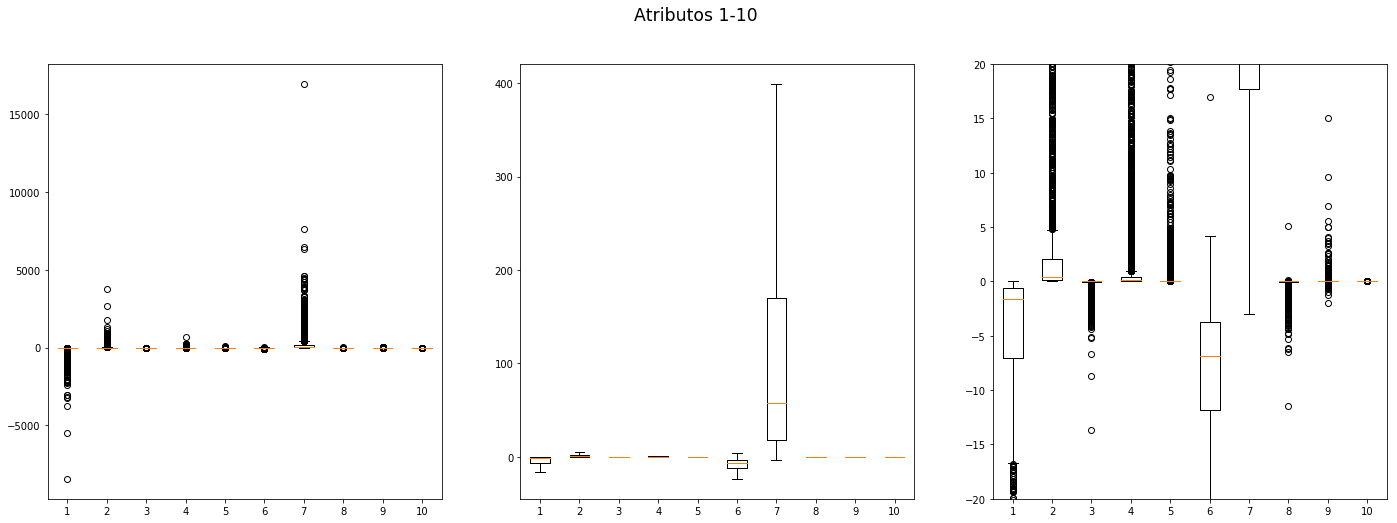

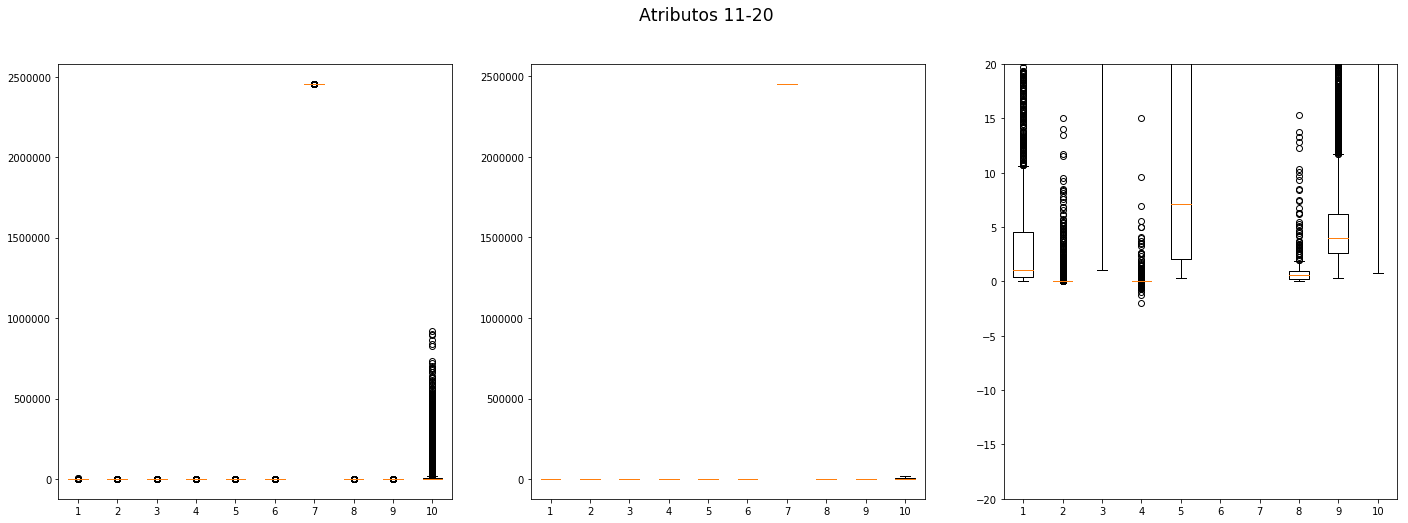

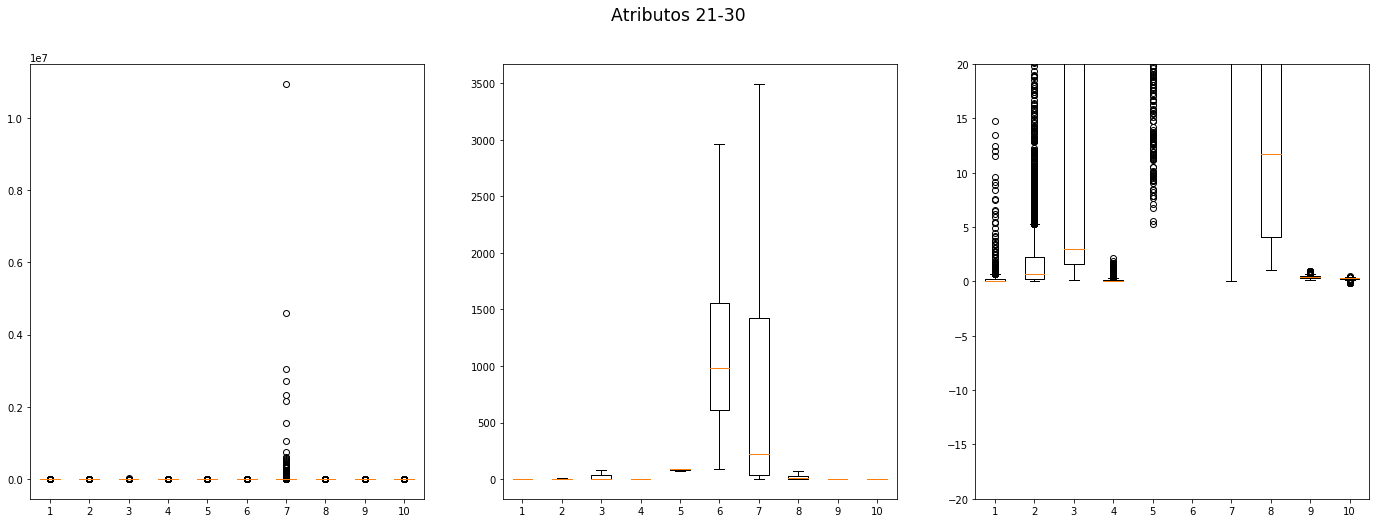

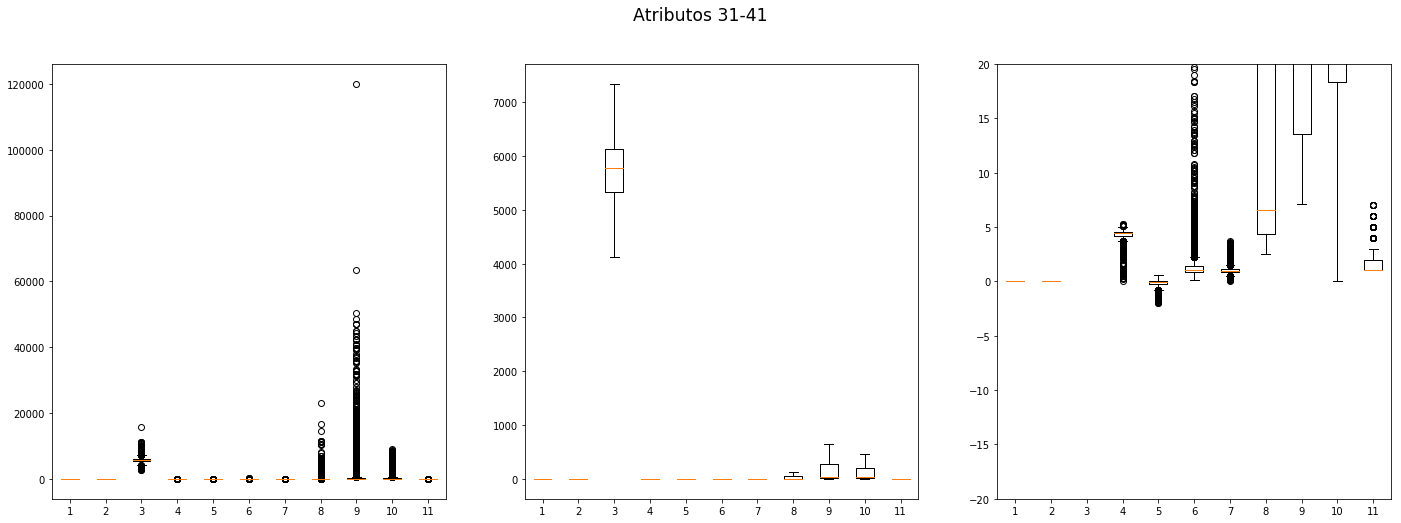

In [20]:
fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 1-10", fontsize='xx-large')
axes[0].boxplot(X_train[:,0:10])
axes[1].boxplot(X_train[:,0:10], sym="")
axes[2].boxplot(X_train[:,0:10])
axes[2].set_ylim(-20,20)


fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 11-20", fontsize='xx-large')
axes[0].boxplot(X_train[:,10:20])
axes[1].boxplot(X_train[:,10:20], sym="")
axes[2].boxplot(X_train[:,10:20])
axes[2].set_ylim(-20,20)


fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 21-30", fontsize='xx-large')
axes[0].boxplot(X_train[:,20:30])
axes[1].boxplot(X_train[:,20:30], sym="")
axes[2].boxplot(X_train[:,20:30])
axes[2].set_ylim(-20,20)


fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 31-41", fontsize='xx-large')
axes[0].boxplot(X_train[:,30:])
axes[1].boxplot(X_train[:,30:], sym="")
axes[2].boxplot(X_train[:,30:])
axes[2].set_ylim(-20,20)

Problema de transformar un vector $X$ en un valor categórico (0 o 1).

- Los atributos están en distinta escala?
- Muchos atributos (dimensiones)
- No es simple determinar la importancia de cada atributo para formar un modelo.

**b) Escalamiento.**

Ayuda a tener una varianza similar entre los distintos atributos. Un atributo con una varianza de ordenes de magnitud mayor al resto de los atributos, puede tener una influencia mayor que el resto en el modelo independiente de la importancia real del atributo.


In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test) # ???
X_test_scaled =  scaler.transform(X_test)

Conjunto de validación, manteniendo desbalanceo

Se extrae el 20% de elementos de cada clase (*confirmed* y *no confirmed*)

In [0]:
# Conjunto validacion
n_cl1 =int(sum(y_train)*.2)
n_cl0 =int((len(y_train)-sum(y_train))*.2)
idx_cl1 = np.random.choice(np.arange(len(y_train))[y_train.astype(dtype=bool)], n_cl1, replace=False)
idx_cl0 = np.random.choice(np.arange(len(y_train))[np.logical_not(y_train)], n_cl0, replace=False)

X_val_scaled = np.append(X_train_scaled[idx_cl1], X_train_scaled[idx_cl0], axis=0)
y_val = np.ones(n_cl1 + n_cl0)
y_val[n_cl1:] = 0

# Saca del conjunto de entrenamiento los elementos que ahora estan en validacion
idx_aux = np.ones(len(y_train), dtype=bool)
idx_aux[idx_cl1] = False
idx_aux[idx_cl0] = False
X_train_scaled = X_train_scaled[idx_aux]
y_train = y_train[idx_aux]

**c) sigmoid vs relu**

In [0]:
from matplotlib.lines import Line2D

def plotModel(N, mid_activ, optim, batchsz=None, l1=None, l2=None, eps=100, title=None, text=None):
    model = None
    fig, ax = plt.subplots(1, 1, figsize=(20,8))
    for i in range(N):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], 
                        kernel_initializer='uniform', activation=mid_activ, 
                        kernel_regularizer=l2, activity_regularizer=l1))
        model.add(Dense(1, kernel_initializer='uniform', activation="sigmoid", 
                        kernel_regularizer=l2, activity_regularizer=l1))
        model.compile(optimizer=optim, loss='binary_crossentropy')
        hist = model.fit(X_train_scaled, y_train, batch_size=batchsz, epochs=eps, verbose=0, validation_data=(X_val_scaled, y_val))
        ax.plot(range(eps), hist.history["loss"], 'o')
        ax.plot(range(eps), hist.history["val_loss"], 'x')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.text(0.85, 0.80, 'Activation: {}'.format(mid_activ), transform=ax.transAxes, fontsize="large")
    h = (Line2D([], [], lw=0, color='green', marker="o", markersize=10), 
         Line2D([], [], lw=0, color='blue', marker='x', markersize=10))
    l = ("Train set", "Validation")
    ax.legend(h, l, loc='upper left', bbox_to_anchor=(0.84, 0.98), fontsize='x-large')
    if(title):
        ax.set_title(title, fontsize='xx-large')
    else:
        ax.set_title("Cross Entropy Loss vs epoch", fontsize='xx-large')
    if(text):
        # INFO text => array [dict {x: coord_x, y: coord_y, txt: texto, kw: **kwargs}]
        for tx in text:
            ax.text(tx['x'], tx['y'], tx['txt'], transform=ax.transAxes, **tx["kw"])
    return model

Instructions for updating:
Use tf.cast instead.


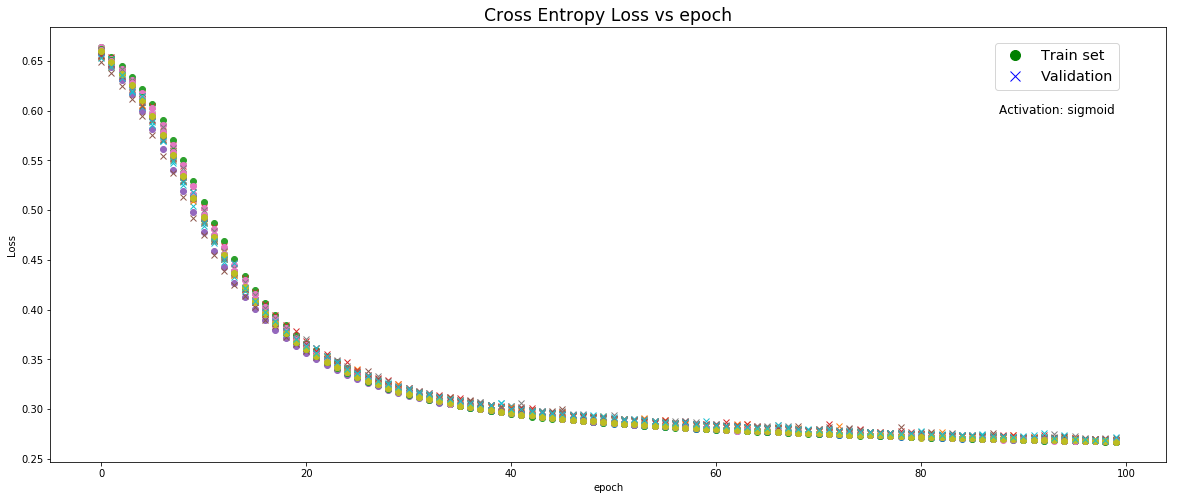

In [15]:
# Sigmoid
model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01))

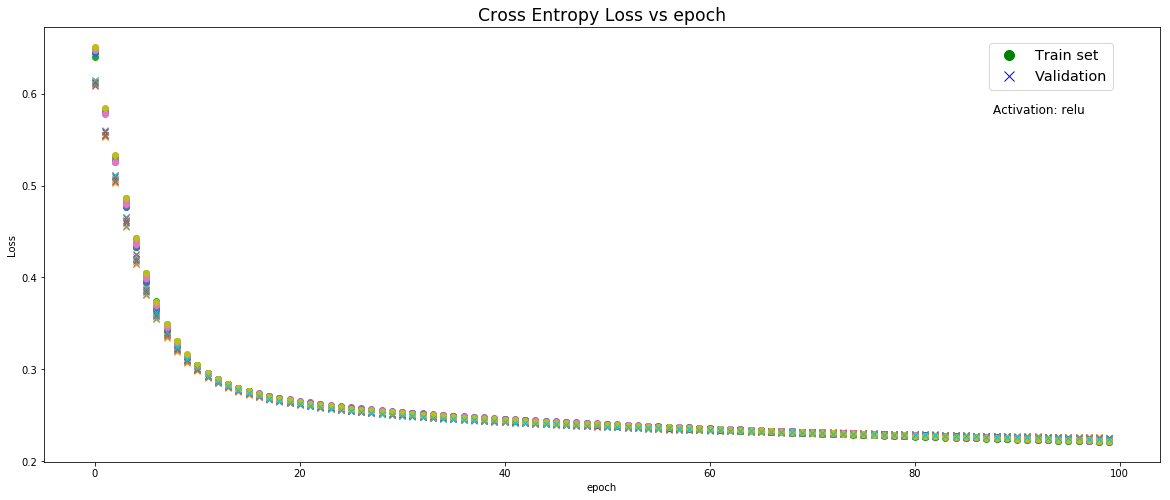

In [16]:
# ReLu
model_relu = plotModel(10, "relu", SGD(lr=0.01))

Metrica f1

In [0]:

f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')
f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')

**d)  Tasa de aprendizaje**

In [0]:
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)

for lrn in learn_rate:
    txt = {'x': 0.8, 'y': 0.8, 'txt': "Learning rate: {:.2g}".format(lrn), 'kw': {}}
    title = "Loss vs epoch (w/Learning rate: {:.2g}".format(lrn)
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=lrn), title=title, text=txt)
    model_relu = plotModel(10, "relu", SGD(lr=lrn), title=title, text=txt)

**e) _Progressive decay_**

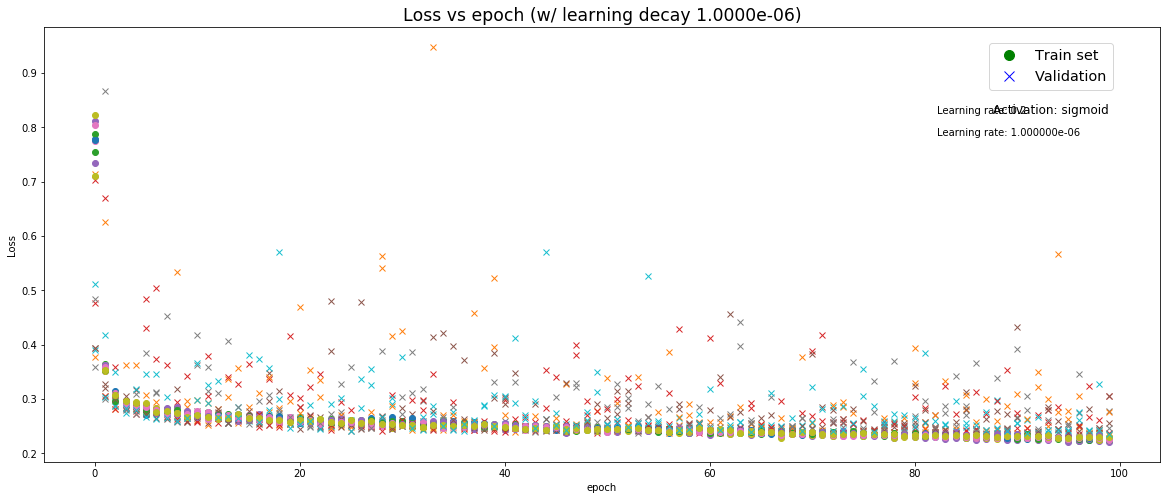

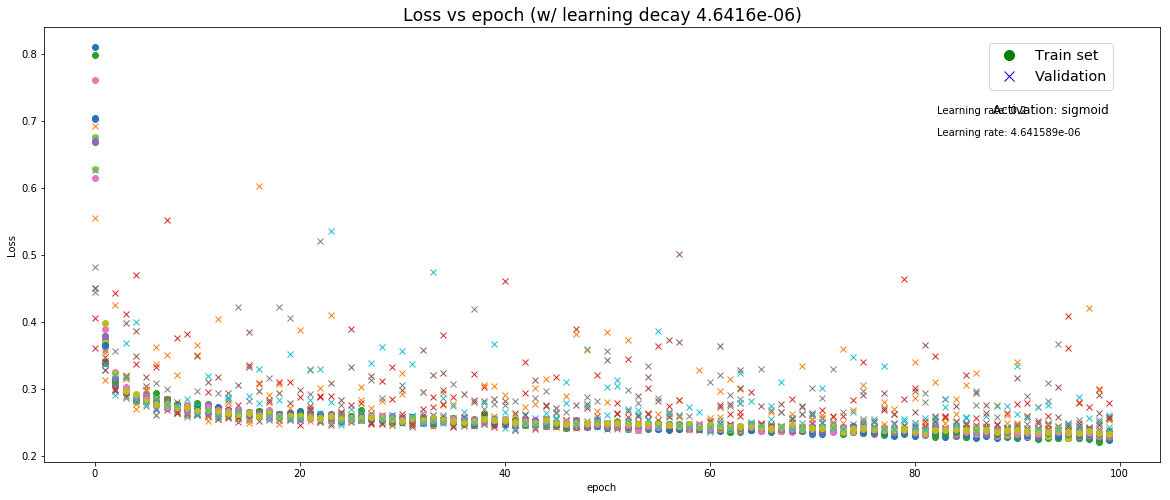

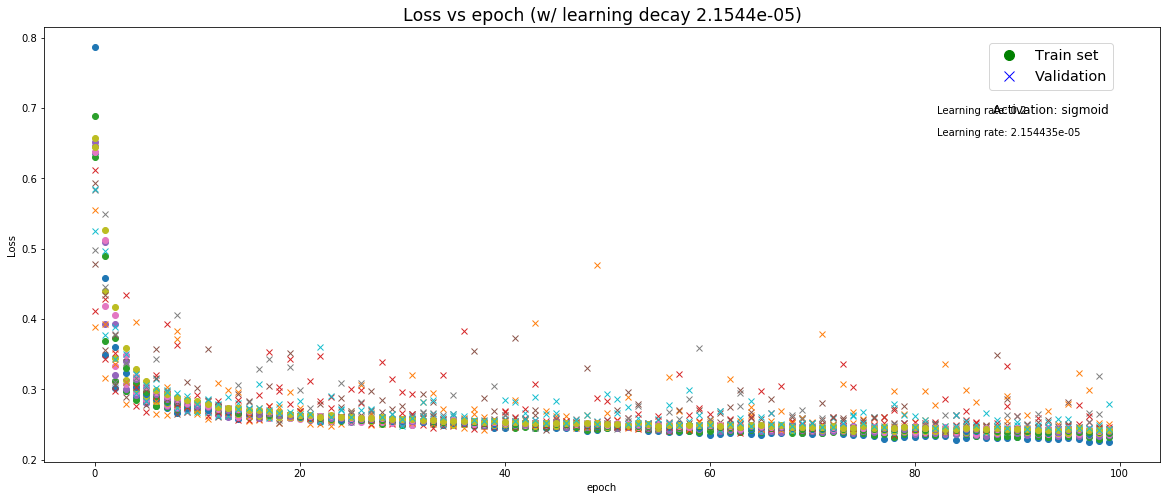

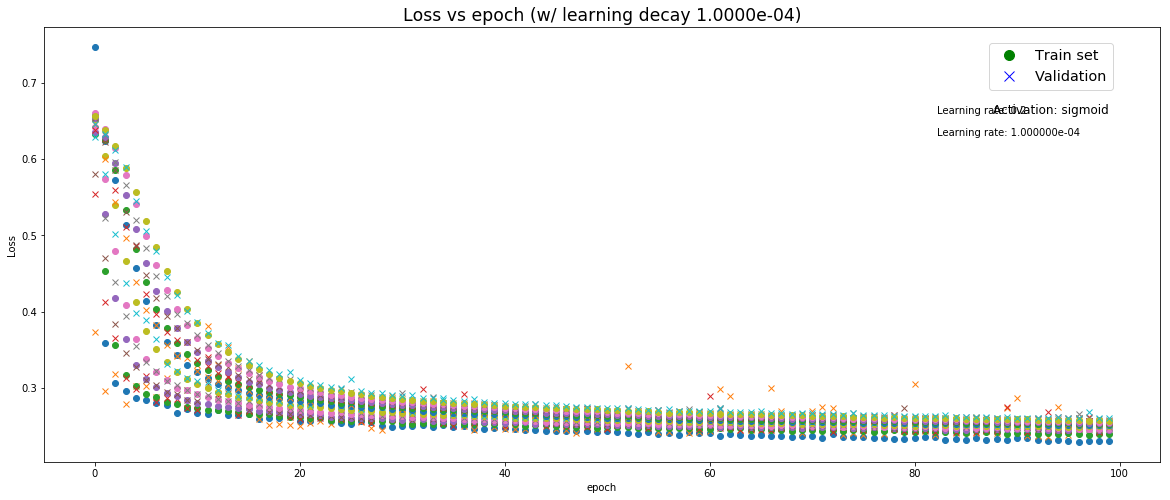

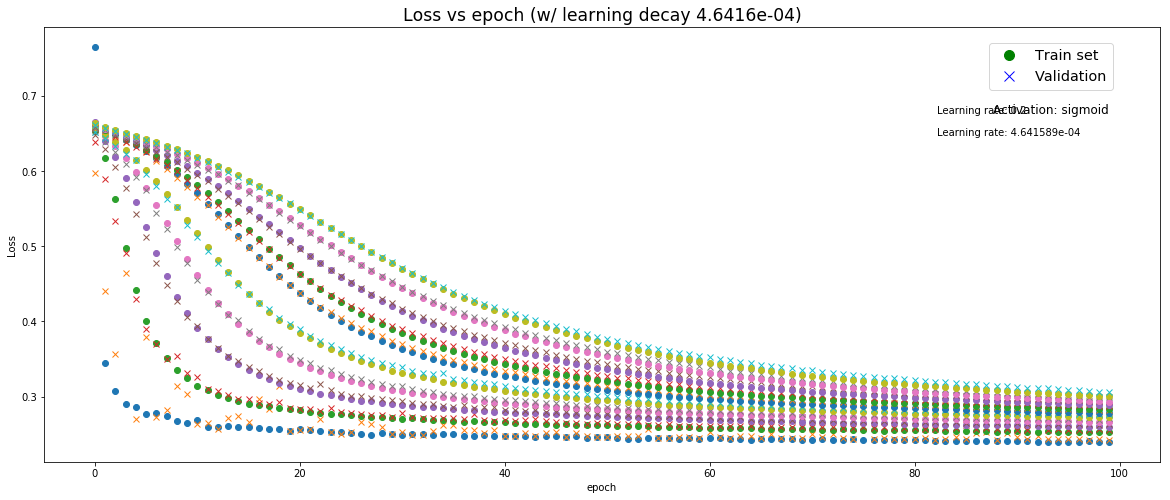

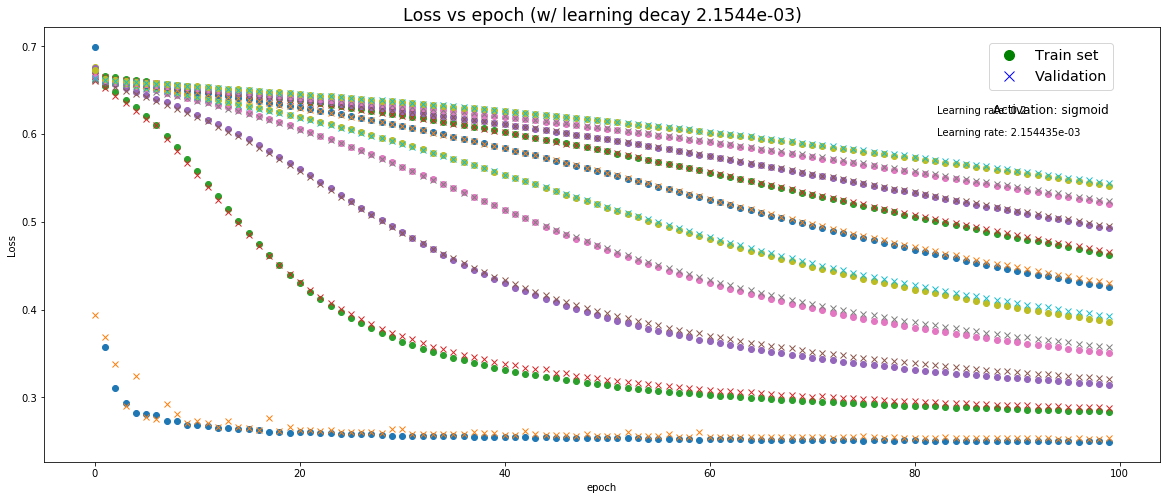

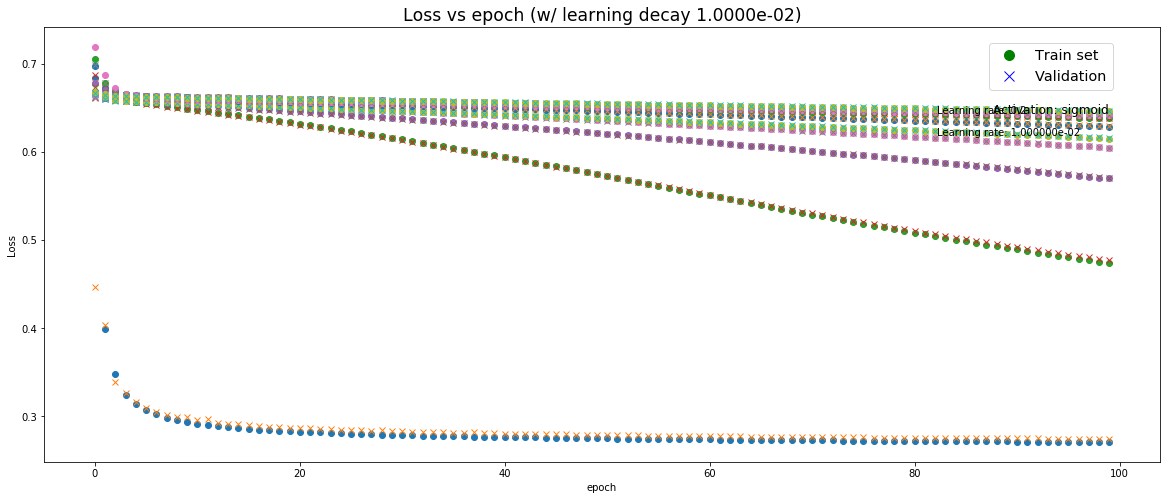

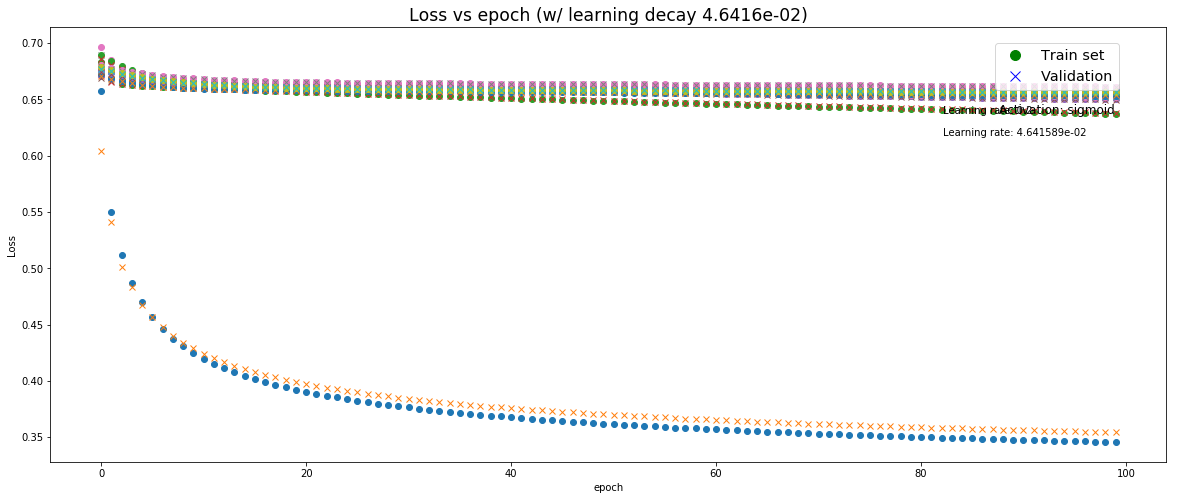

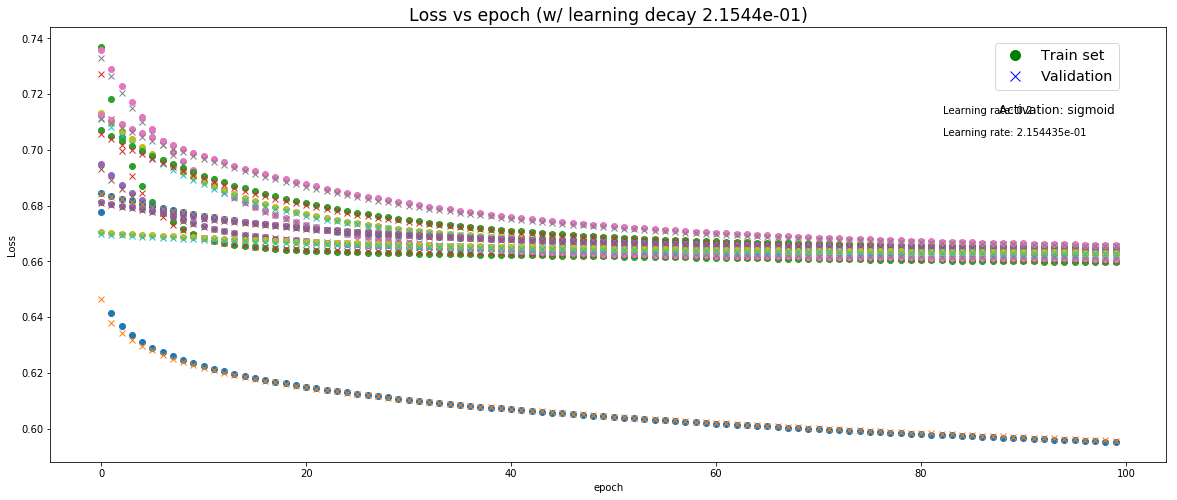

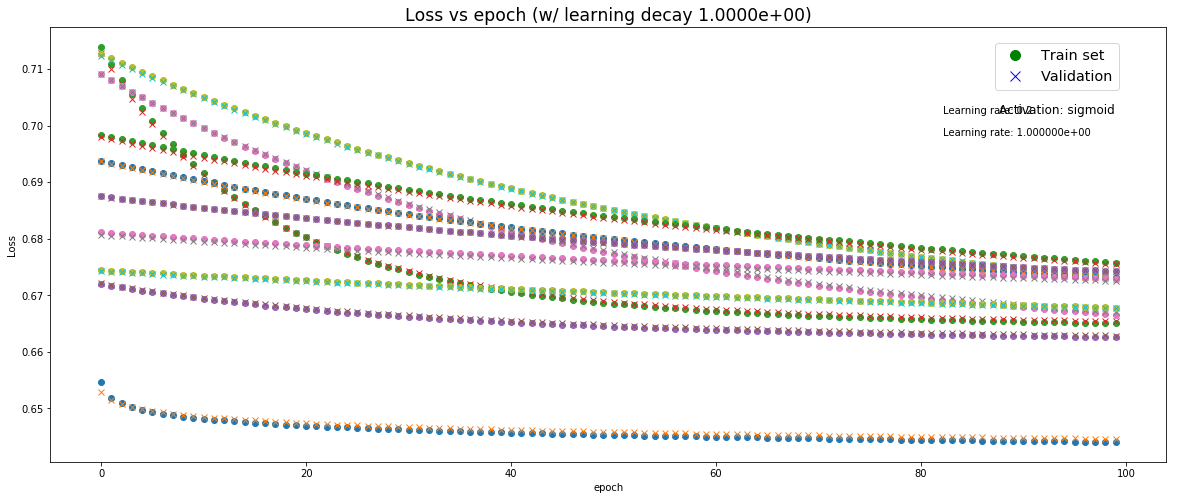

In [17]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)

for lrd in lear_decay:
    txt = [{'x': 0.8, 'y': 0.8, 'txt': "Learning rate: 0.2", 'kw': {}}, 
           {'x': 0.8, 'y': 0.75, 'txt': "Learning rate: {:e}".format(lrd), 'kw': {}}]
    title = "Loss vs epoch (w/ learning decay {:.4e})".format(lrd)
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.2, decay=lrd), title=title, text=txt)

In [0]:
for lrd in lear_decay:
    txt = [{'x': 0.8, 'y': 0.8, 'txt': "Learning rate: 0.2", 'kw': {}}, 
           {'x': 0.8, 'y': 0.75, 'txt': "Learning rate: {:e}".format(lrd), 'kw': {}}]
    title = "Loss vs epoch (w/ learning decay {:.4e})".format(lrd)
    model_relu = plotModel(10, "relu", SGD(lr=0.2, decay=lrd), title=title, text=txt)

**f) Momentum clásico y momentum de Nesterov**

In [0]:
split_space = 21
momentums = np.linspace(0,1,split_space)
# Momentum clásico
print("Momentum clásico\n================")
for mmt in momentums:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Momentum: {:.2g}".format(mmt), 'kw': {}}, 
           {'x': 0.85, 'y': 0.68, 'txt': "Nesterov: False"}, 'kw': {}]
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01, momentum=mmt, nesterov=False), text=txt)
    model_sigmoid = plotModel(10, "relu", SGD(lr=0.01, momentum=mmt, nesterov=False), text=txt)

In [0]:
# Momentum de nesterov
print("Momentum de nesterov\n=====================")
for mmt in momentums:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Momentum: {:.2g}".format(mmt), 'kw': {}}, 
           {'x': 0.85, 'y': 0.68, 'txt': "Nesterov: True"}, 'kw': {}]
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01, momentum=mmt, nesterov=True), text=txt)
    model_sigmoid = plotModel(10, "relu", SGD(lr=0.01, momentum=mmt, nesterov=True), text=txt)

**g) Batch size**

In [0]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches)).astype(dtype=int)

for bsz in batch_sizes:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
           {'x': 0.85, 'y': 0.72, 'txt': "Batch size: {:n}".format(bsz), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (batch_size: {:n})".format(bsz)
    model_sigmoid = plotModel(4, "sigmoid", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)
    #model_relu = plotModel(4, "relu", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)

In [0]:
for bsz in batch_sizes:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
           {'x': 0.85, 'y': 0.72, 'txt': "Batch size: {:n}".format(bsz), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (batch_size: {:n})".format(bsz)
    model_relu = plotModel(4, "relu", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)

**h) Optimizers: Adam, RMSprop, Adagrad & Adadelta**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


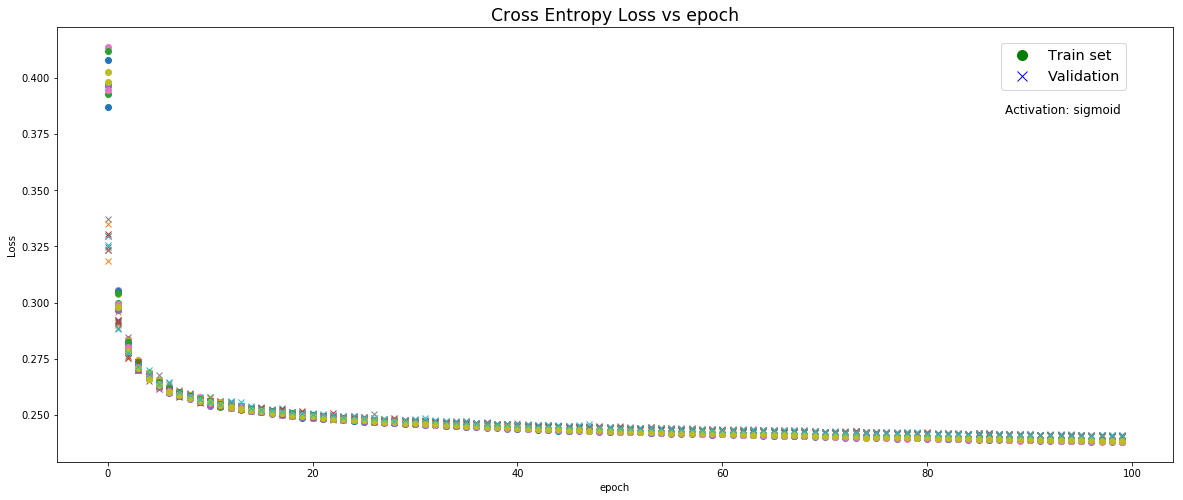

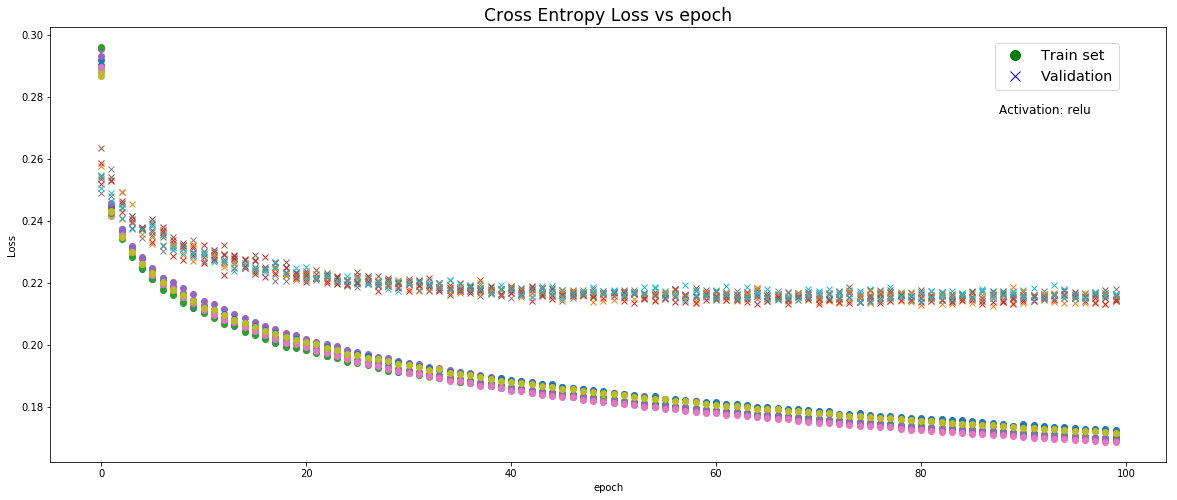

In [12]:
# Adagrad
model_sigmoid = plotModel(10, "sigmoid", Adagrad(lr=0.01))
model_relu = plotModel(10, "relu", Adagrad(lr=0.01))

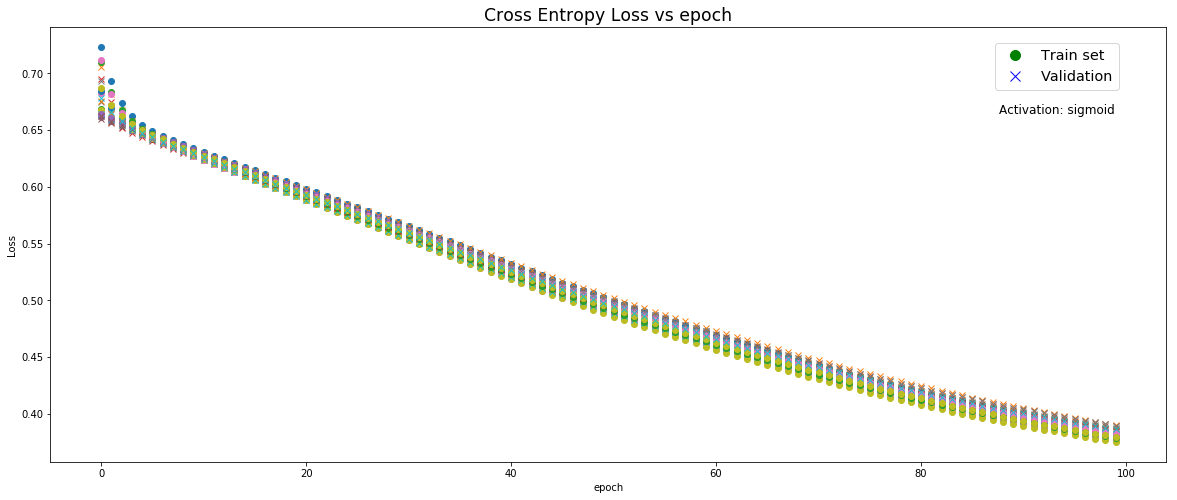

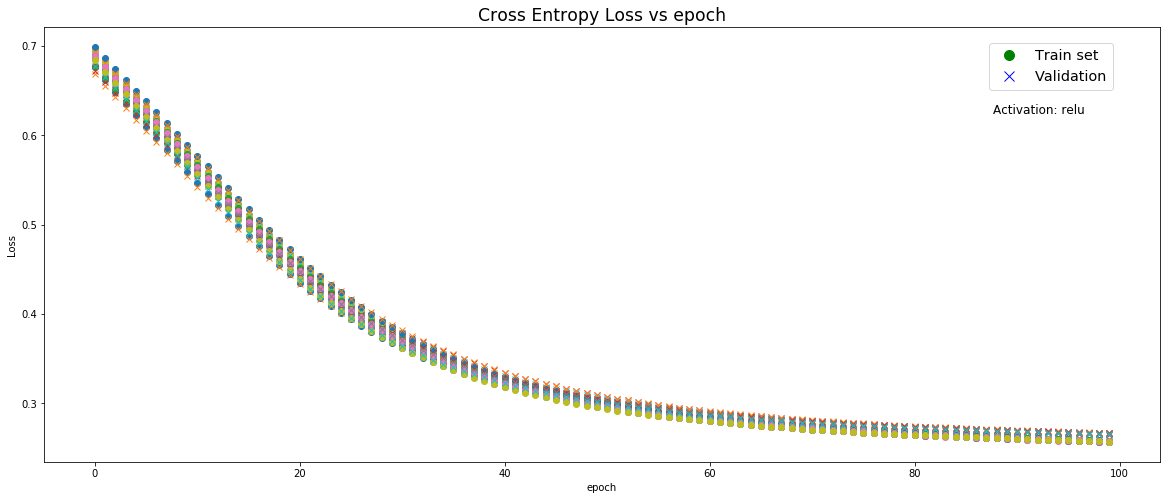

In [13]:
# Adadelta
model_sigmoid = plotModel(10, "sigmoid", Adadelta(lr=0.01))
model_relu = plotModel(10, "relu", Adadelta(lr=0.01))

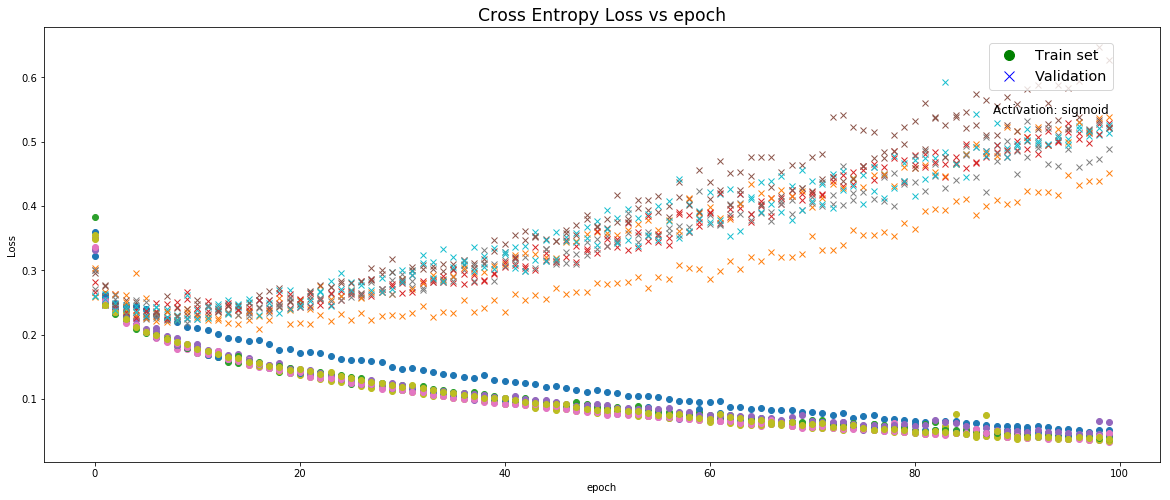

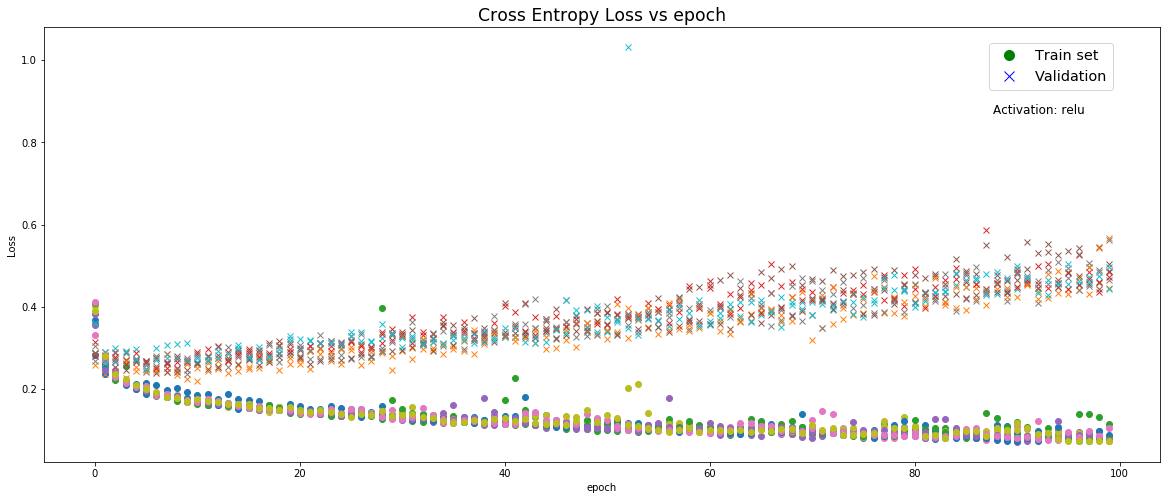

In [14]:
# Adam
model_sigmoid = plotModel(10, "sigmoid", Adam(lr=0.01))
model_relu = plotModel(10, "relu", Adam(lr=0.01))

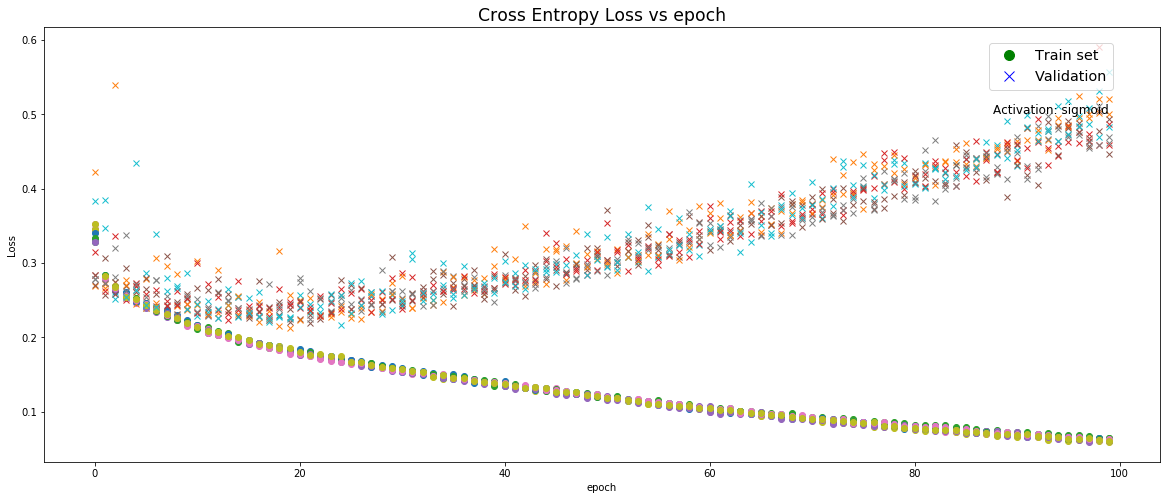

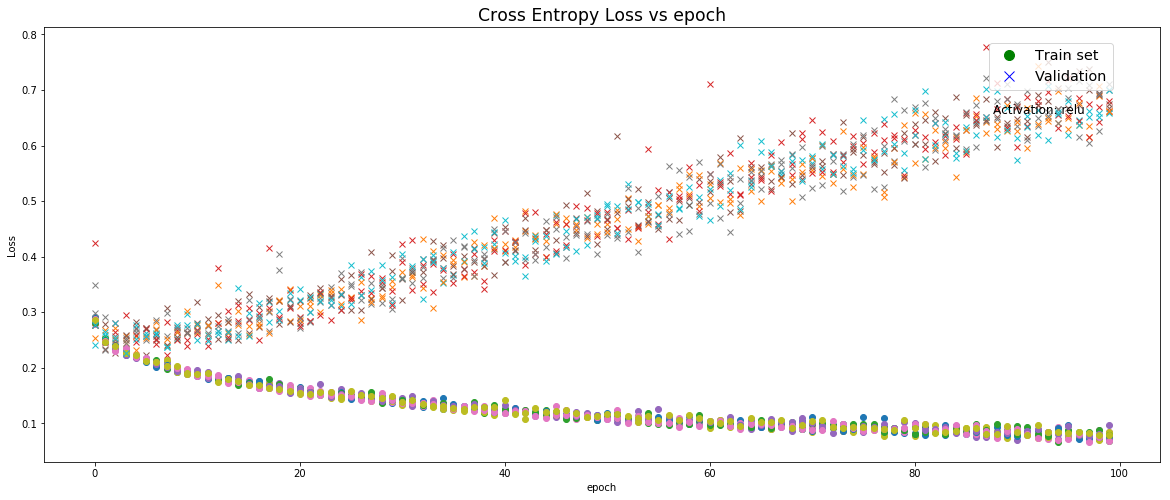

In [15]:
# RMSprop
model_sigmoid = plotModel(10, "sigmoid", RMSprop(lr=0.01))
model_relu = plotModel(10, "relu", RMSprop(lr=0.01))

**i) Regularizadores clásicos $l_1$ y $l_2$**

In [0]:
#TODO rango de los parametros?

n_par = 10
l12_param = np.logspace(-6,0,n_par)

for p in l12_param:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "L1: {:.4e}".format(p), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ Activity Regularizer, L1 = {:.4e})".format(p)
    model_sigmoid = plotModel2(10, "sigmoid", SGD(lr=0.01), l1=l1(p), title=title, text=txt)
    model_relu = plotModel2(10, "relu", SGD(lr=0.01), l1=l1(p), title=title, text=txt)

In [0]:
for p in l12_param:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "L2: {:.4e}".format(p), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ Kerner regularizer, L2 = {:.4e})".format(p)
    model_sigmoid = plotModel2(10, "sigmoid", SGD(lr=0.01), l2=l2(p), title=title, text=txt)
    model_relu = plotModel2(10, "relu", SGD(lr=0.01), l1=l1(p), title=title, text=txt)

**j)**

<a id="segundo"></a>
## 2. *Deep Networks*

<a id="tercero"></a>
## 3. Redes Convolucionales en Imágenes

<a id="cuarto"></a>
## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico